In [1]:
#run this command to install required libraries
#pip install -r requirements.txt

In [2]:
import pickle
import cProfile
import pstats
import os

In [3]:
current_directory = os.getcwd()  # Get the current working directory
parent_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
print("Parent Directory:", parent_directory)

Parent Directory: C:\Users\Administrator.DESKTOP-D3SVMI5\Documents\GitHub\PySeirCity-Hybrid-ABM-EBM-Epi-Model


In [4]:
# Load serialized data 
with open(parent_directory+'\\data\\dates.pkl', 'rb') as file:
    dates = pickle.load(file)
    
with open(parent_directory+'\\data\\facility_date_time_step_urbano_agent_dic.pkl', 'rb') as file:
    facility_date_time_step_urbano_agent_dic = pickle.load(file)
with open(parent_directory+'\\data\\urbano_agent_date_time_step_facility_dic.pkl', 'rb') as file:
    urbano_agent_date_time_step_facility_dic = pickle.load(file)
    
with open(parent_directory+'\\data\\urbano_agents_travelers_mapping.pkl', 'rb') as file:
    urbano_agents_travelers_mapping = pickle.load(file)
with open(parent_directory+'\\data\\traveler_urbano_agent_mapping.pkl', 'rb') as file:
    traveler_urbano_agent_mapping = pickle.load(file)
    
with open(parent_directory+'\\data\\time_use_baseline_dict.pkl', 'rb') as file:
    time_use_baseline_dict = pickle.load(file)
with open(parent_directory+'\\data\\county_mobility_changes_dict.pkl', 'rb') as file:
    county_mobility_changes_dict = pickle.load(file)
with open(parent_directory+'\\data\\stationary_distributions.pkl', 'rb') as file:
    stationary_distributions = pickle.load(file)
with open(parent_directory+'\\data\\facility_to_index.pkl', 'rb') as file:
    facility_to_index = pickle.load(file)

In [5]:
from facility import Facility
from megaagent import State, MegaAgent

from seirstat import Statistics
from preprocessing import SimulationPeriodBasicInfo
from parameters import Parameters, VariedInfectionDurationResponse
from interventions import GeneralTesting, ContactTracing
from simulation import Simulation

G:\Anaconda\envs\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Debug

In [6]:
# repetitions = 1
# initial_exposed_count = 10
# # discount percentage of hazard brought by an asymptomatic individual
# asym_hazard_multiplier = 0.5

# parameters = Parameters(repetitions, initial_exposed_count, asym_hazard_multiplier)
# parameters.infection_duration = VariedInfectionDurationResponse(rate_from_S_to_E=2,
#                                                                 rate_from_E_to_I=1/2, 
#                                                                 rate_from_asymI_to_R=1/8, 
#                                                                 rate_from_symI_to_R=1/8, 
#                                                                 asym_fraction=0, 
#                                                                 asym_hazard_multiplier=asym_hazard_multiplier)


# # enable this block if conduct testing, and quarantine
# parameters.probs_to_be_tested = {"S":0.1,"E":0.4,"Is":0.8,"Ia":0.4,"R":0.1} 
# parameters.test_accuracy_rate = 0.8
# parameters.quarantine_prob = 0.5
# parameters.conduct_testing = GeneralTesting(parameters.probs_to_be_tested, 
#                                             parameters.test_accuracy_rate,
#                                             parameters.quarantine_prob,
#                                             parameters.quarantine_length)

# # Create simulation_period_basic_info object
# simulation_period_basic_info = SimulationPeriodBasicInfo(dates,
#                                                          facility_date_time_step_urbano_agent_dic,
#                                                          urbano_agent_date_time_step_facility_dic,
#                                                          urbano_agents_travelers_mapping,
#                                                          traveler_urbano_agent_mapping,
#                                                          time_use_baseline_dict,
#                                                          county_mobility_changes_dict,
#                                                          stationary_distributions,
#                                                          facility_to_index)

In [7]:
# # Create all Facility objects
# all_facilities_objects = {}
# for f_name in simulation_period_basic_info.AllFacilityNames:
#     facility_object = Facility(f_name, simulation_period_basic_info)
#     all_facilities_objects[f_name] = facility_object


# # Create all MegaAgents
# all_mega_agents = {}
# for MegaAgentName in simulation_period_basic_info.mega_agent_Urbano_mapping.keys():
#     travelers_in_mega_agent = simulation_period_basic_info.MegaAgent_Travelers[MegaAgentName]   
#     if travelers_in_mega_agent==0:
#         continue
        
#     mega_agent = MegaAgent(MegaAgentName,travelers_in_mega_agent,simulation_period_basic_info)
#     all_mega_agents[MegaAgentName] = mega_agent

# # initialize Statistics
# stat = Statistics(all_mega_agents, dates)

In [8]:
# def reset_facilities_and_MegaAgents() -> None:
#     for facility_name, facility in all_facilities_objects.items():
#         facility.reset_facility()
#     for mega_agent_name, mega_agent in all_mega_agents.items():
#         mega_agent.reset_MegaAgent()

In [9]:
# %%time
# with cProfile.Profile() as pr: 

#     for _ in range(repetitions):
# #         initial_infectious = np.random.choice(list(simulation_period_basic_info.AllTravelers), 
# #                                               replace = False, 
# #                                               size = parameters.initial_exposed_count)
#         initial_infectious = list(simulation_period_basic_info.AllTravelers)[:parameters.initial_exposed_count]

#         for mega_agent_name, mega_agent in all_mega_agents.items():
#             if mega_agent.MegaAgentPopulation == 0:
#                 continue

#             if not mega_agent.MegaAgentState.S_set.isdisjoint(initial_infectious):
#                 initial_infectious_travelers_in_mega_agent = list(mega_agent.MegaAgentState.S_set.intersection(initial_infectious))
#             else:
#                 continue

#             first_date = dates[0]
#             UrbanoAgents = simulation_period_basic_info.mega_agent_Urbano_mapping[(mega_agent.MegaAgentName[0], mega_agent.MegaAgentName[1])]
#             mega_agent.dynamic_time_spent_dic = MegaAgent.get_dynamic_time_spent(first_date,
#                                                                                 UrbanoAgents,
#                                                                                 simulation_period_basic_info)

#             MegaAgent.initialize_MegaAgent(first_date, 
#                                            parameters,
#                                            mega_agent.MegaAgentState.S_set,
#                                            mega_agent.MegaAgentState.Is_dict,
#                                            mega_agent.MegaAgentState.Ia_dict,
#                                            mega_agent.MegaAgentState.Is_set,
#                                            mega_agent.MegaAgentState.Ia_set,
#                                            mega_agent.new_Is_count,
#                                            mega_agent.new_Ia_count,
#                                            mega_agent.MegaAgentState.R_dict,
#                                            mega_agent.MegaAgentState.Q_dict,
#                                            mega_agent.MegaAgentState.Qe_dict,
#                                            mega_agent.MegaAgentState.Qa_dict,
#                                            mega_agent.MegaAgentState.Qs_dict,
#                                            initial_infectious_travelers_in_mega_agent)
#             mega_agent.record_daily_stat(first_date, stat)   
#             parameters.conduct_testing.test(mega_agent,
#                                             first_date,
#                                             all_facilities_objects,
#                                             simulation_period_basic_info)
#             mega_agent.if_initialized = True


#         for date in dates:
#             print(date)

#             # On each day, at the first time step, calculate dynamic time spent for each travelers
#             for mega_agent_name, mega_agent in all_mega_agents.items():
#                 if mega_agent.if_initialized == True and date == dates[0]:
#                     continue
#                 UrbanoAgents = simulation_period_basic_info.mega_agent_Urbano_mapping[(mega_agent.MegaAgentName[0], mega_agent.MegaAgentName[1])]
#                 mega_agent.dynamic_time_spent_dic = MegaAgent.get_dynamic_time_spent(date,
#                                                                                      UrbanoAgents,
#                                                                                      simulation_period_basic_info)

#             for time_step in range(1,7):
#                 for f_name, f in all_facilities_objects.items():
#                     f.FacilityHazard = Facility.computeFacilityHazard(f_name,
#                                                                       f.FaciltyIndex,
#                                                                       date,
#                                                                       time_step,
#                                                                       all_mega_agents, 
#                                                                       parameters, 
#                                                                       simulation_period_basic_info,
#                                                                       f.DateTimeStepAllVisitors)
#                 for mega_agent_name, mega_agent in all_mega_agents.items():
#                     if mega_agent.MegaAgentPopulation == 0:
#                         continue

#                     if mega_agent.if_initialized == True and date == dates[0] and time_step == 1:
#                         continue
#                     else:
#                         MegaAgent.labelTravelsAsExposed(mega_agent_name,
#                                                         date, 
#                                                         time_step,
#                                                         parameters,
#                                                         all_facilities_objects,
#                                                         simulation_period_basic_info,
#                                                         mega_agent.dynamic_time_spent_dic,
#                                                         mega_agent.MegaAgentState.S_set,
#                                                         mega_agent.MegaAgentState.E_dict,
#                                                         mega_agent.MegaAgentState.V_dict)

#             # daily update 
#             for mega_agent_name, mega_agent in all_mega_agents.items():
#                 if mega_agent.MegaAgentPopulation == 0:
#                     continue
#                 if mega_agent.if_initialized == True and date == dates[0]:
#                     continue
                                    
#                 (mega_agent.new_Is_count, mega_agent.new_Ia_count) = MegaAgent.MegaAgent_daily_update(date, 
#                                                                                                       parameters,
#                                                                                                       mega_agent.MegaAgentState.S_set,
#                                                                                                       mega_agent.MegaAgentState.E_dict,
#                                                                                                       mega_agent.MegaAgentState.Is_dict,
#                                                                                                       mega_agent.MegaAgentState.Ia_dict,
#                                                                                                       mega_agent.MegaAgentState.Is_set,
#                                                                                                       mega_agent.MegaAgentState.Ia_set,
#                                                                                                       mega_agent.MegaAgentState.R_dict,
#                                                                                                       mega_agent.MegaAgentState.Q_dict,  
#                                                                                                       mega_agent.MegaAgentState.Qe_dict,
#                                                                                                       mega_agent.MegaAgentState.Qa_dict,
#                                                                                                       mega_agent.MegaAgentState.Qs_dict) 
#                 mega_agent.record_daily_stat(date, stat)
#                 parameters.conduct_testing.test(mega_agent,
#                                                 date,
#                                                 all_facilities_objects,
#                                                 simulation_period_basic_info)
                
#         reset_facilities_and_MegaAgents()

In [10]:
# st = pstats.Stats(pr)
# st.sort_stats(pstats.SortKey.TIME)
# st.print_stats()

In [11]:
# stat.plot_aggregated_progression(parameters)
# stat.plot_MegaAgents_progressions()

In [12]:
# stat.Reff_agg

# Basic Simulation

Running 2 repetitions.
Initial exposed: 10
Simulation days: 45 days, 0:00:00


Overall Progress: 100%|████████████████████████████████████████████████████████████████| 90/90 [02:05<00:00,  1.39s/it]


Average final exposure count is 96041.5
Sample Standard deviation is: 539.5224740453358


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CPU times: total: 2min 11s
Wall time: 2min 12s


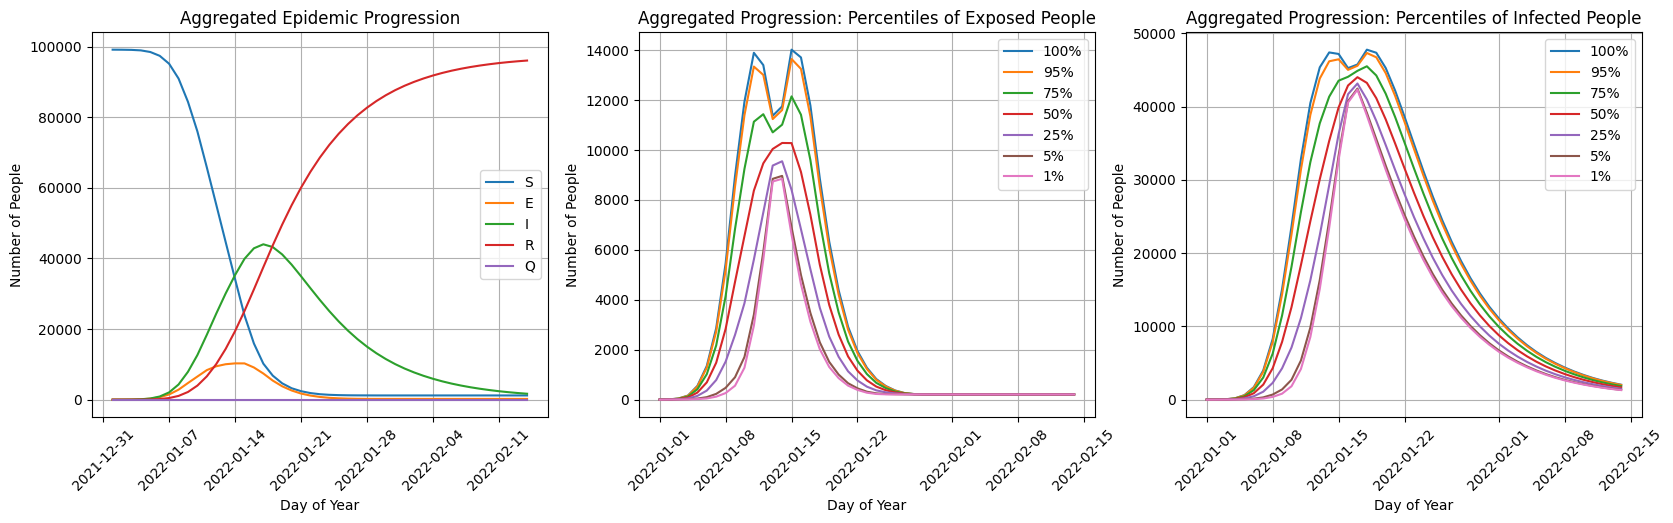

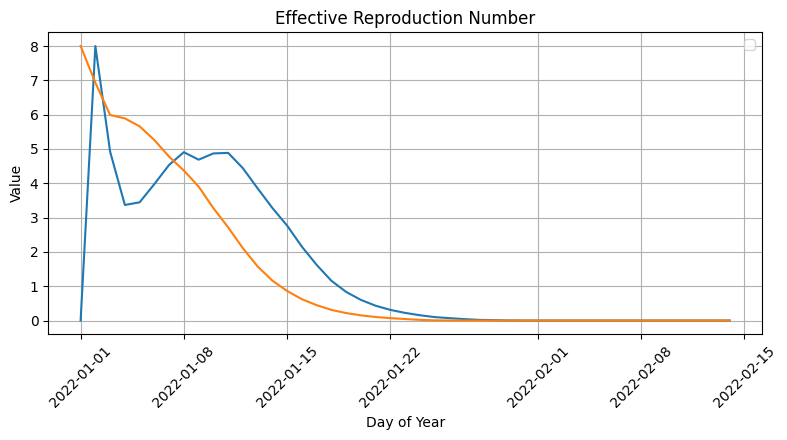

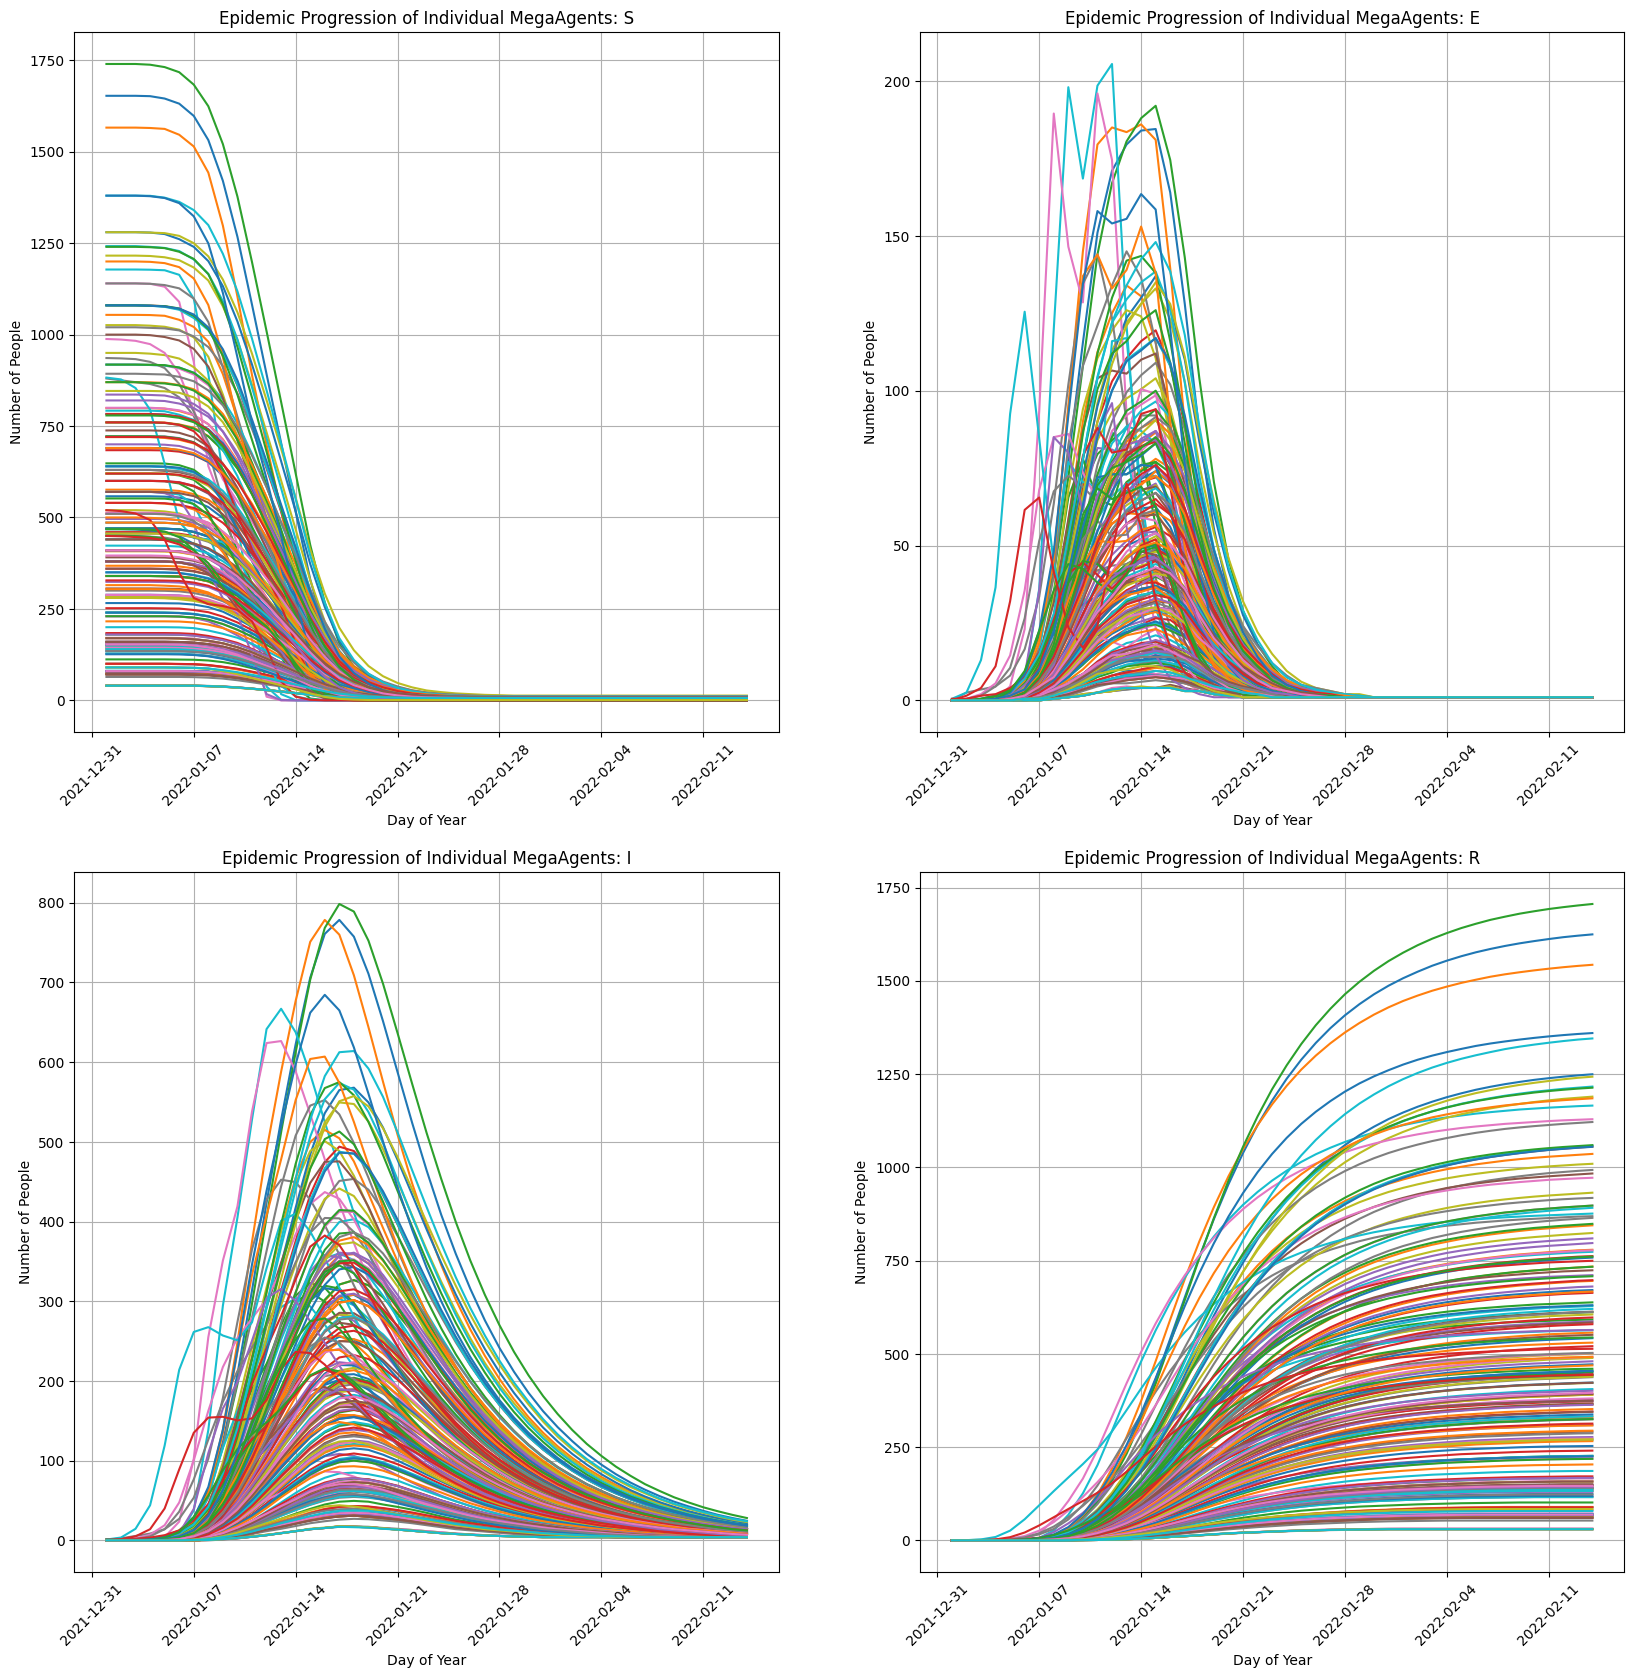

In [20]:
%%time

# specify how many times you wanna run simulation
repetitions = 2
initial_exposed_count = 10
# discount percentage of hazard brought by an asymptomatic individual
asym_hazard_multiplier = 0.5

parameters = Parameters(repetitions, initial_exposed_count, asym_hazard_multiplier)
parameters.infection_duration = VariedInfectionDurationResponse(rate_from_S_to_E=2,
                                                                rate_from_E_to_I=1/2, 
                                                                rate_from_asymI_to_R=1/8, 
                                                                rate_from_symI_to_R=1/8, 
                                                                asym_fraction=0, 
                                                                asym_hazard_multiplier=asym_hazard_multiplier)


# Create simulation_period_basic_info object
simulation_period_basic_info = SimulationPeriodBasicInfo(dates,
                                                         facility_date_time_step_urbano_agent_dic,
                                                         urbano_agent_date_time_step_facility_dic,
                                                         urbano_agents_travelers_mapping,
                                                         traveler_urbano_agent_mapping,
                                                         time_use_baseline_dict,
                                                         county_mobility_changes_dict,
                                                         stationary_distributions,
                                                         facility_to_index)

simulation = Simulation(dates, 
                         simulation_period_basic_info, 
                         parameters, 
                         simulation_period_basic_info.AllFacilityNames)

simulation.run()

# Testing & Quarantine

Running 1 repetitions.
Initial exposed: 10
Simulation days: 45 days, 0:00:00


Overall Progress: 100%|████████████████████████████████████████████████████████████████| 45/45 [01:01<00:00,  1.36s/it]


Average final exposure count is 81215.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CPU times: total: 1min 8s
Wall time: 1min 8s


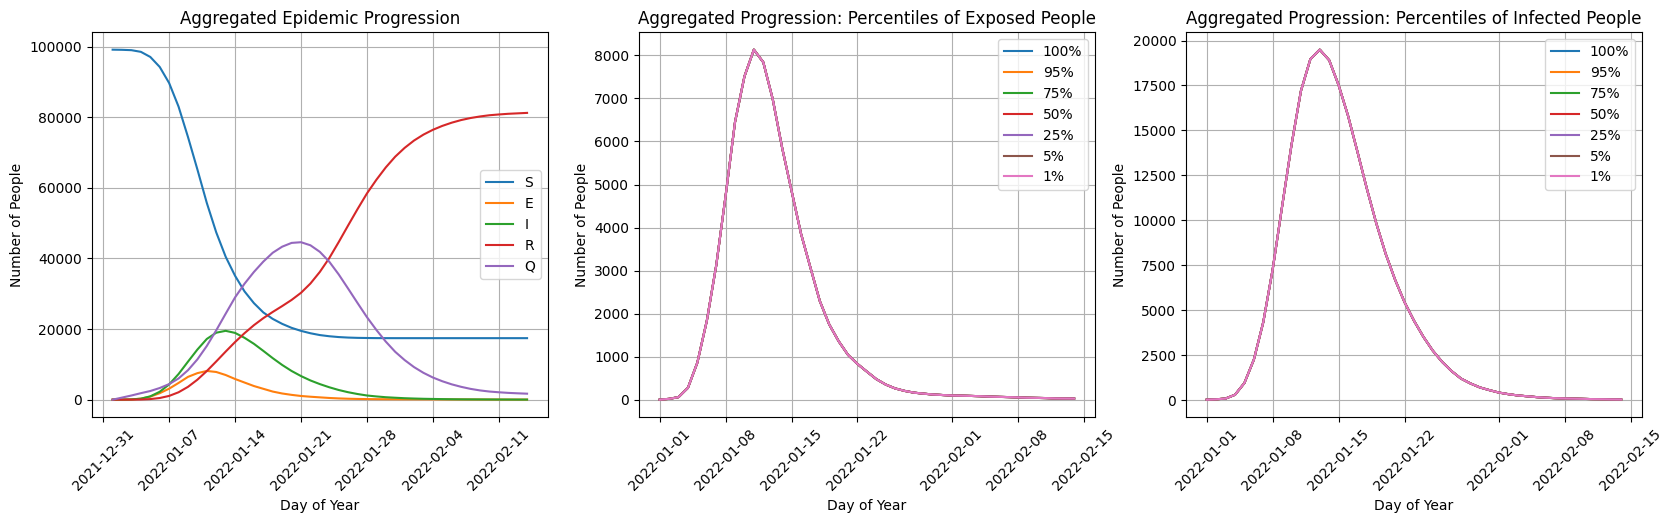

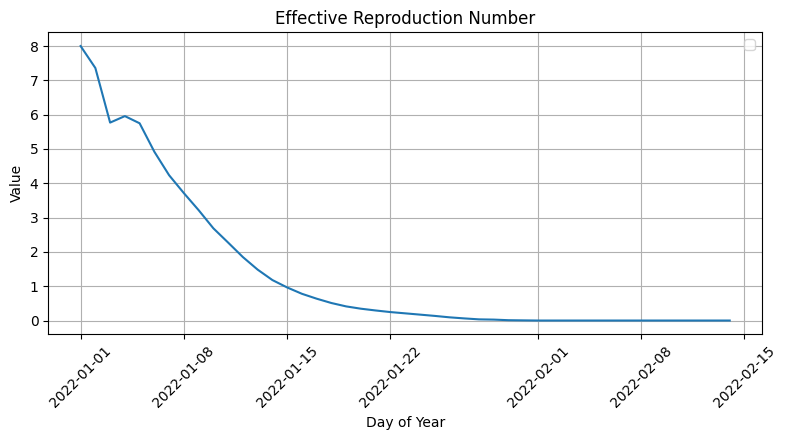

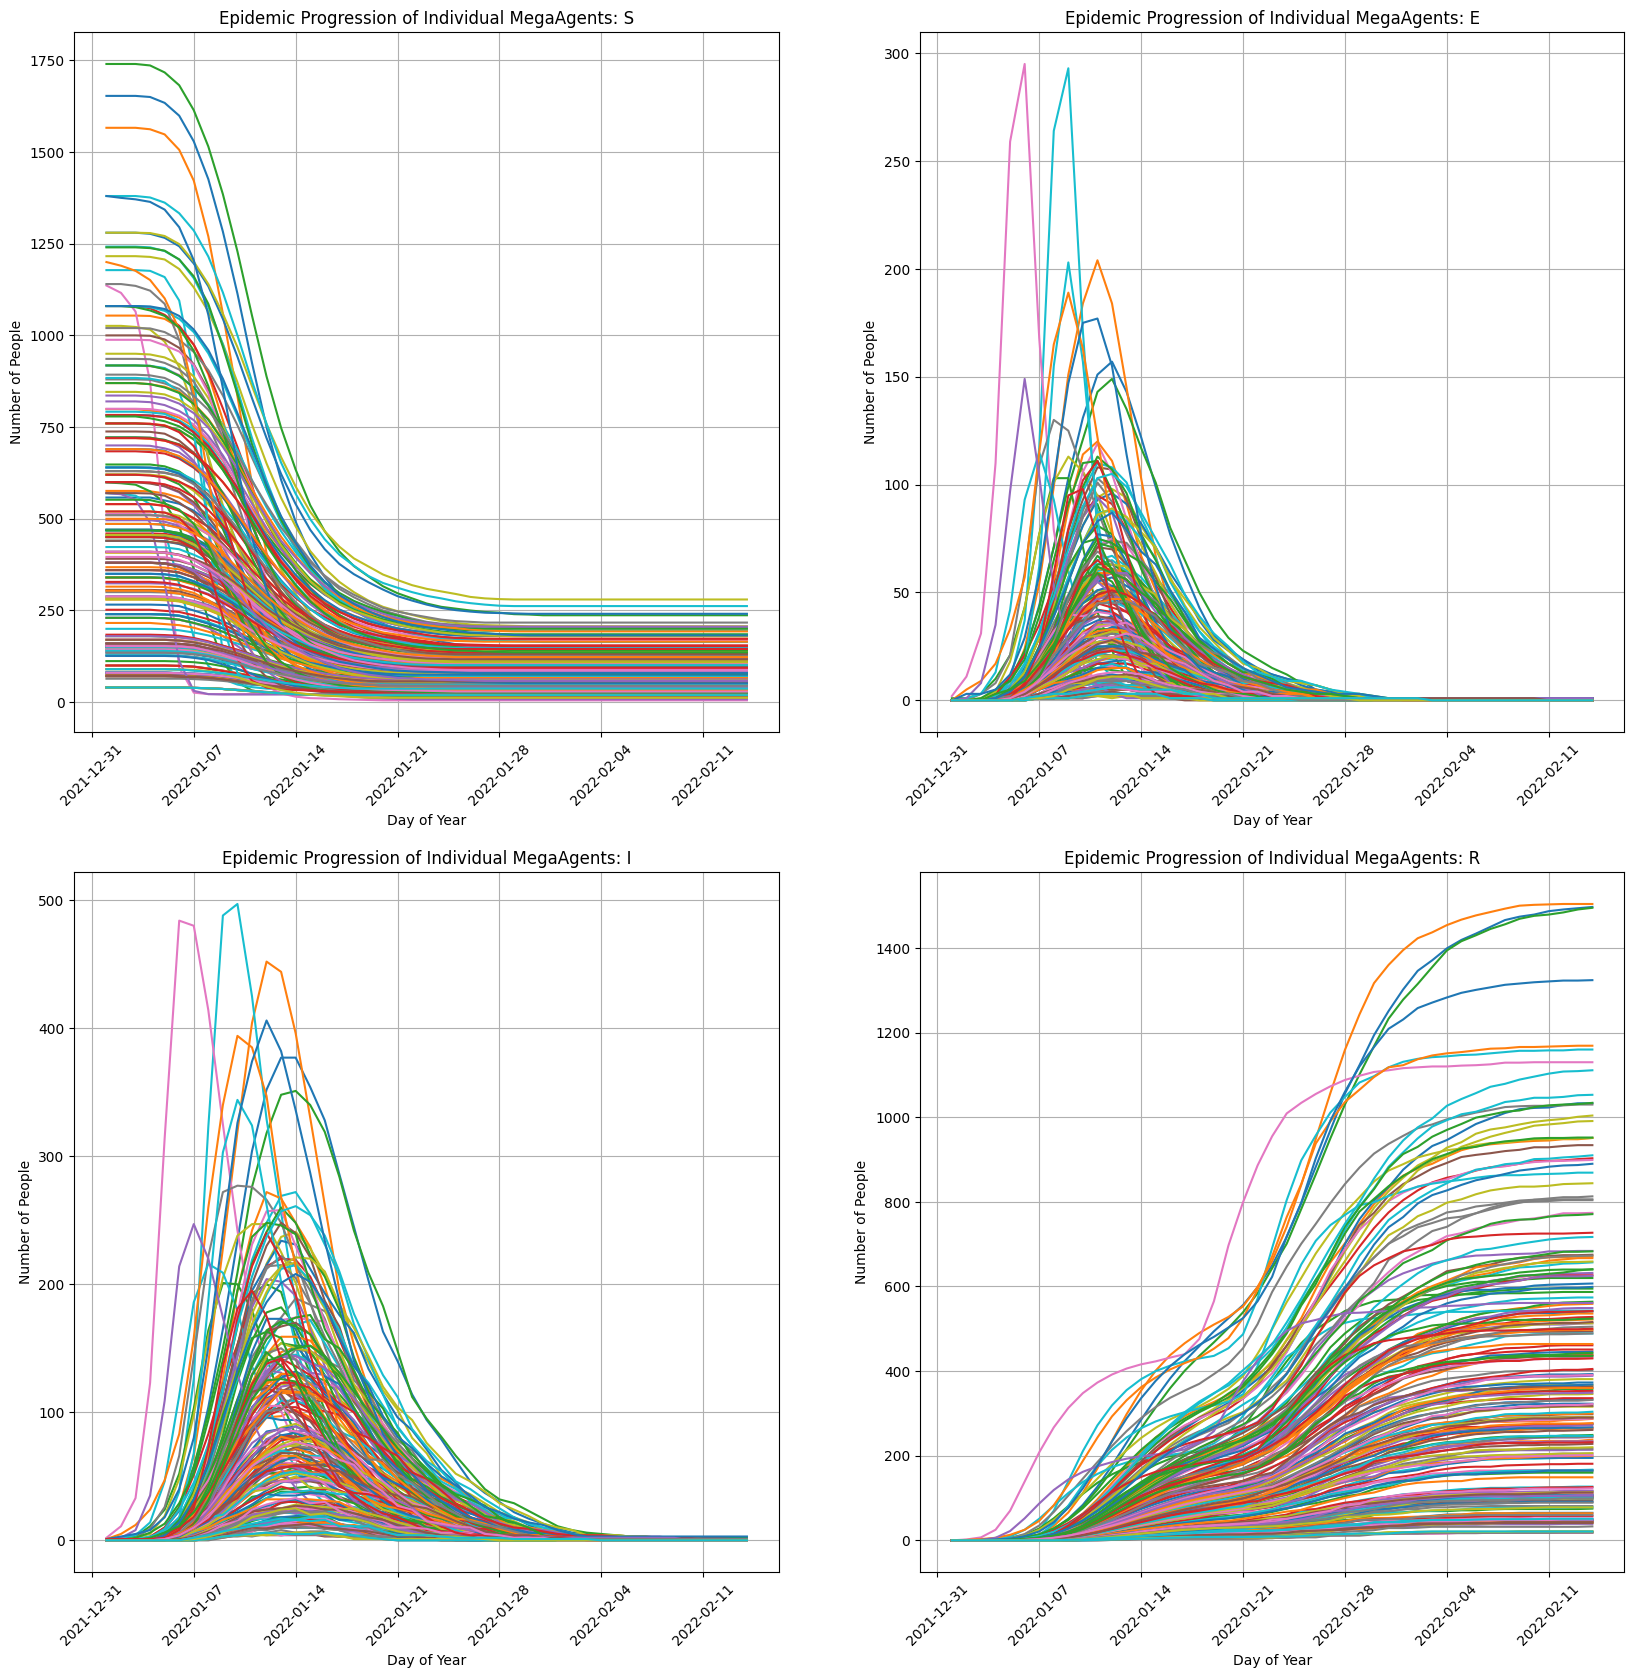

In [19]:
%%time

# specify how many times you wanna run simulation
repetitions = 1
initial_exposed_count = 10
# discount percentage of hazard brought by an asymptomatic individual
asym_hazard_multiplier = 0.5

parameters = Parameters(repetitions, initial_exposed_count, asym_hazard_multiplier)
parameters.infection_duration = VariedInfectionDurationResponse(rate_from_S_to_E=2,
                                                                rate_from_E_to_I=1/2, 
                                                                rate_from_asymI_to_R=1/8, 
                                                                rate_from_symI_to_R=1/8, 
                                                                asym_fraction=0, 
                                                                asym_hazard_multiplier=asym_hazard_multiplier)


# enable this block if conduct testing, and quarantine
parameters.probs_to_be_tested = {"S":0.1,"E":0.4,"Is":0.8,"Ia":0.4,"R":0.1} 
parameters.test_accuracy_rate = 0.8
parameters.quarantine_prob = 0.3
parameters.conduct_testing = GeneralTesting(parameters.probs_to_be_tested, 
                                            parameters.test_accuracy_rate,
                                            parameters.quarantine_prob,
                                            parameters.quarantine_length)

# Create simulation_period_basic_info object
simulation_period_basic_info = SimulationPeriodBasicInfo(dates,
                                                         facility_date_time_step_urbano_agent_dic,
                                                         urbano_agent_date_time_step_facility_dic,
                                                         urbano_agents_travelers_mapping,
                                                         traveler_urbano_agent_mapping,
                                                         time_use_baseline_dict,
                                                         county_mobility_changes_dict,
                                                         stationary_distributions,
                                                         facility_to_index)

simulation = Simulation(dates, 
                        simulation_period_basic_info, 
                        parameters, 
                        simulation_period_basic_info.AllFacilityNames)

simulation.run()